### Image segmentation notebook based on [semantic_segmentation_pascalvoc](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/semantic_segmentation_pascalvoc/semantic_segmentation_pascalvoc.ipynb) 

In [30]:
%%time
import sagemaker
from sagemaker import get_execution_role
import os
import boto3 
import time
import shutil
import random

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
role='arn:aws:iam::395166463292:role/service-role/AmazonSageMaker-ExecutionRole-20200714T182988'
from PIL import Image

profile = 'sites'
region_name='us-east-2'
bucket = 'st-crayon-dev'
prefix = 'sagemaker/site_tech_drone_img_seg/'

 
session = boto3.session.Session(profile_name = profile, region_name = region_name)
sess = sagemaker.Session(session,default_bucket=bucket)
print(sess.boto_session)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Session(region_name='us-east-2')
CPU times: user 31.2 ms, sys: 31.2 ms, total: 62.5 ms
Wall time: 63.8 ms


In [13]:
sm = session.client(service_name = 'sagemaker')

experiment_name = f'site-tech-drone-img-seg'

experiments = []

for exp in Experiment.list(sagemaker_boto_client=sm):
    experiments.append(exp.experiment_name)

print(experiments)

if experiment_name not in experiments:
    experiment = Experiment.create(experiment_name=experiment_name,
                                   description="semantic segmentation of drone pictures",
                                   sagemaker_boto_client=sm)
experiment_name = experiments[0]                                   
print(f'Experiment used for notebook = {experiment_name}')

['site-tech-drone-img-seg']
Experiment used for notebook = site-tech-drone-img-seg


In [14]:
trial_name = f'semantic-segmentation-drone-dataset-{int(time.time())}'
ss_trial = Trial.create(trial_name = trial_name,
                          experiment_name = experiment_name,
                          sagemaker_boto_client = sm,
                          tags = [{'Key': 'experiment_name', 'Value': 'aws-ss-drone-dataset'}])
ss_trial

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fecf6cf95b0>,trial_name='semantic-segmentation-drone-dataset-1595937719',experiment_name='site-tech-drone-img-seg',tags=[{'Key': 'experiment_name', 'Value': 'aws-ss-drone-dataset'}],trial_arn='arn:aws:sagemaker:us-east-2:395166463292:experiment-trial/semantic-segmentation-drone-dataset-1595937719',response_metadata={'RequestId': '9ea6bfed-6a85-4215-874b-29ab2bb2d9e1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9ea6bfed-6a85-4215-874b-29ab2bb2d9e1', 'content-type': 'application/x-amz-json-1.1', 'content-length': '119', 'date': 'Tue, 28 Jul 2020 12:01:59 GMT'}, 'RetryAttempts': 0})

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:latest


In [17]:
s3_output_location = f's3://{bucket}/{prefix}output'
s3_output_location

's3://st-crayon-dev/sagemaker/site_tech_drone_img_seg/output'

In [86]:
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role=role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.2xlarge',
                                         train_volume_size = 10,
                                         train_max_run = 7200,
                                         train_max_wait=7200,
                                         output_path = s3_output_location,
                                         base_job_name = f'ss-drone-images-{int(time.time())}',
                                         train_use_spot_instances=True,
                                         input_mode='File',
                                         sagemaker_session = sess,
                                         enable_sagemaker_metrics=True)

In [87]:
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='deeplab', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=26, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=50, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=2, # No matter what, run these many number of epochs.                             
                             num_training_samples=343) # This is a mandatory parameter, 1464 in this case.

In [88]:
train_channel = prefix + 'train'
validation_channel = prefix + 'validation'
train_annotation_channel = prefix + 'train_annotation'
validation_annotation_channel = prefix + 'validation_annotation'

s3_train_data = f's3://{bucket}/{train_channel}/'
s3_validation_data = f's3://{bucket}/{validation_channel}/'
s3_train_annotation = f's3://{bucket}/{train_annotation_channel}/'
s3_validation_annotation = f's3://{bucket}/{validation_annotation_channel}/'

In [89]:
distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}
data_channels

{'train': <sagemaker.inputs.s3_input at 0x7fecf5871af0>,
 'validation': <sagemaker.inputs.s3_input at 0x7fecf5871c70>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7fecf5871820>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7fecf5871df0>}

In [90]:
ss_model.fit(inputs=data_channels,
             logs=True,
             experiment_config={
                "TrialName": ss_trial.trial_name,
                "TrialComponentDisplayName": "Training",
                },
             wait=True
            )

ch: 17, validation throughput: 31.0128676829 samples/sec.
[07/28/2020 14:43:07 INFO 140110473017152] #progress_metric: host=algo-1, completed 36 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 18, "sum": 18.0, "min": 18}}, "EndTime": 1595947387.831525, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "AWS/Semantic Segmentation", "epoch": 17}, "StartTime": 1595947368.432539}

[07/28/2020 14:43:22 INFO 140110473017152] #progress_notice. epoch: 18, iterations:

In [93]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: ss-drone-images-1595946770-2020-07-28-14-33-01-077
INFO:sagemaker:Creating endpoint with name ss-drone-images-1595946770-2020-07-28-14-33-01-077
---------------------!

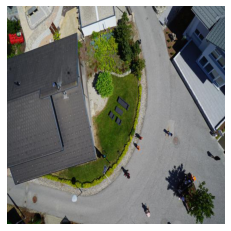

In [117]:
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

# resize image size for inference
filename = '../data/interim/semantic_drone_dataset/test/202.jpg'
filename_mask = '../data/interim/semantic_drone_dataset/test_annotation/202.png'
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")



plt.imshow(im)
plt.axis('off')
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)

In [118]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 9.74 s


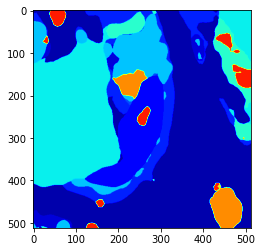

In [119]:
from PIL import Image
import numpy as np
import io

num_classes = 26
mask = np.array(Image.open(io.BytesIO(return_img)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

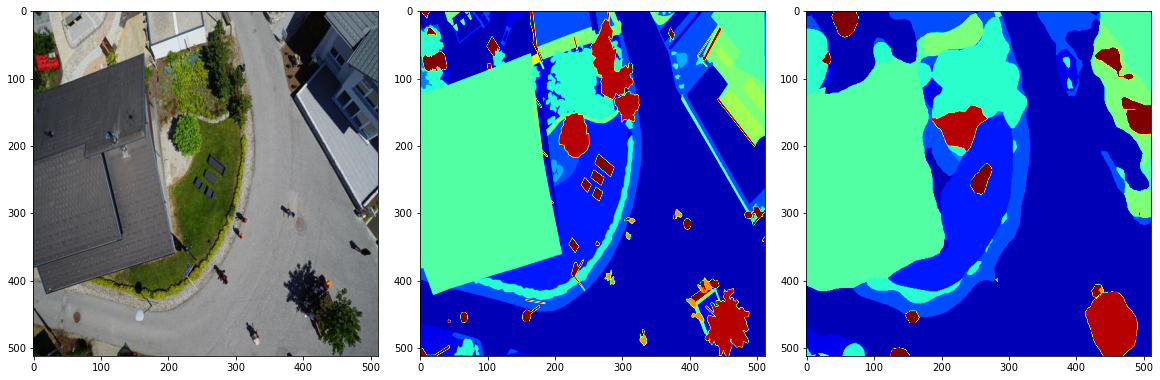

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(Image.open(filename))
axs[0].grid(False)
axs[1].imshow(Image.open(filename_mask), vmin=0, vmax=num_classes-1, cmap='jet')
axs[1].grid(False)
axs[2].imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
axs[2].grid(False)